In [622]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import pprint
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [623]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  86


In [624]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,test_against_epsilons,lambdas,taus,ps,dp,d,experiment_type,completed,data_model_type,data_model_name,data_model_description,gamma_fair_error
226,686d625b-4995-41ec-be9a-37359d7bb042,Sweep Alpha - VanillaGaussian - VanillaGaussia...,116.583199,"[""Logistic""]",86,2023-11-27 17:36:06,1,2,"[0.1995, 0.7943]","[0.0, 0.4]","[0.2, 0.6]",[0.001],"[0, 1]",null,0.01,1000,Sweep,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...,0.01


In [625]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [626]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[experiment_loc]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[experiment_loc]["data_model_name"]
data_model_description = df_experiments.iloc[experiment_loc]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

686d625b-4995-41ec-be9a-37359d7bb042
Sweep
VanillaGaussian VanillaGaussian
A Data-Model with Identity Gaussians for all the covariances.
Sweep Alpha - VanillaGaussian - VanillaGaussian - A Data-Model with Identity Gaussians for all the covariances.
['Logistic']


In [627]:

state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]


erm = df_erm[df_erm["experiment_id" ] == experiment_id]

gd = erm[erm["chosen_minimizer"] == "sklearn"]



# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon"]) #,"p_calibration"
# from state_evolution keep generalization_error, sigma, q, m, angle
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","angle","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","test_loss","adversarial_generalization_error_teacher","fair_adversarial_error","F","P"]] #calibration
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	angle
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","angle", "training_error","d", "training_loss","test_loss","adversarial_generalization_error","adversarial_generalization_error_overlap","A","N", "adversarial_generalization_error_teacher","fair_adversarial_error","P","F"]] #,"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','angle_state_evolution','angle_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","test_loss_state_evolution", "adversarial_generalization_error_teacher_erm","adversarial_generalization_error_teacher_state_evolution","fair_adversarial_error_state_evolution","fair_adversarial_error_erm","P_state_evolution","P_erm","F_state_evolution","F_erm"]] #,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4,5]).agg(["mean","std"]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df.sort_index()
df

generalization_error_state_evolution  \
                                                                                     mean   
alpha  epsilon tau lam   problem_type attack_epsilon                                        
0.1995 0.0     0.0 0.001 Logistic     0.2                                        0.387386   
                                      0.6                                        0.387386   
               1.0 0.001 Logistic     0.2                                        0.445773   
                                      0.6                                        0.445773   
       0.4     0.0 0.001 Logistic     0.2                                        0.387484   
                                      0.6                                        0.387484   
               1.0 0.001 Logistic     0.2                                        0.445889   
                                      0.6                                        0.445889   
0.7943 0.0     0.0 0.001 Logistic     0.2                                        0.281349   
                                      0.6                                        0.281349   
               1.0 0.001 Logistic     0.2                                        0.404557   
                                      0.6                                        0.404557   
       0.4     0.0 0.001 Logistic     0.2                                        0.282640   
                                      0.6                                        0.282640   
               1.0 0.001 Logistic     0.2                                        0.406055   
                                      0.6                                        0.406055   

                                                           \
                                                      std   
alpha  epsilon tau lam   problem_type attack_epsilon        
0.1995 0.0     0.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
               1.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
       0.4     0.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
               1.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
0.7943 0.0     0.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
               1.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
       0.4     0.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   
               1.0 0.001 Logistic     0.2             0.0   
                                      0.6             0.0   

                                                     generalization_error_erm_erm  \
                                                                             mean   
alpha  epsilon tau lam   problem_type attack_epsilon                                
0.1995 0.0     0.0 0.001 Logistic     0.2                                0.388095   
                                      0.6                                0.388095   
               1.0 0.001 Logistic     0.2                                0.439595   
                                      0.6                                0.439595   
       0.4     0.0 0.001 Logistic     0.2                                0.379620   
                                      0.6                                0.379620   
               1.0 0.001 Logistic     0.2                                0.437305   
                                      0.6                                0.437305   
0.7943 0.0     0.0 0.001 Logistic     0.2                                0.275335   
                                      0.6                                0.275335   
               1.0 0

In [628]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [629]:
first_iteration = "tau"
second_iteration = None #"lam" # "lam"
target = "alpha"
sweep = "epsilon"
save_plots = False
description = ""

def get_path(problem_type, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if filename is None:
        filename = description
    
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    for attack_epsilon in attack_epsilons:

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                for lam in iterate_over:

                    fig = plt.figure()
                    ax = plt.subplot(111)

                    # Filter the dataframe for the current values of tau and lam
                    if second_iteration is None:
                        data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]
                    else:
                        data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]

                    if fix_a_variable is not None:
                        data = data[data[fix_a_variable] == variable_value]
                    
                    for i, epsilon in enumerate(data[sweep].unique()):
                        # Filter the dataframe for the current value of epsilon
                        epsilon_subset = data[data[sweep] == epsilon]

                        # Plot the state_evolution results as a line
                        if state_evolution_name is not None:
                            if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                            else:
                                ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                        
                        # Plot the gradient_descent results as points with error bars
                        if gd_name is not None:
                            try:
                                ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                            except:
                                pass

                        if error_name == "Generalization Error" and target == "lam":
                            optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                            # plot the optimal lambda as a vertical line
                            if optimal_lambda is not None:
                                ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                    
                    if log_x:
                        plt.xscale('log')
                        # plt.xscale('symlog')
                    if log_y:
                        plt.yscale('log')

                    # Add labels and title
                    plt.xlabel(target)
                    plt.ylabel(error_name)
                    title = f"{error_name} - {problem_type} - {first_iteration}: {tau},"
                    if fix_a_variable is not None:
                        if second_iteration is None:
                            title += f' d: {d} - {fix_a_variable}: {variable_value}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}'
                    else:
                        if second_iteration is None:
                            title += f' d: {d}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d}'
                    if plot_attack_epsilon:
                        title += f" - attack_epsilon: {attack_epsilon}"
                    plt.title(title,y=1.1)
                    

                    box = ax.get_position()
                    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                    # Put a legend to the right of the current axis
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                    # add a grid
                    plt.grid()

                    plt.tight_layout()

                    if fix_a_variable is not None:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                    else:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                    if plot_attack_epsilon:
                        name += f"_attack_epsilon_{attack_epsilon}"
                    # Save the plot as svg
                    if filename is not None or save_plots:


                        path = get_path(problem_type, filename)

                        plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                    # Show the plot
                    plt.show()


In [630]:
# Write some code to store all information about the data_model in a json file next to all the plots
if save_plots:
    for problem_type in experiment_problem_types:
        path = get_path(problem_type)

        # get an ExperimentInformation object from one entry in df_experiments
        experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

        # load the data_model and store it in a dictionary
        data_model = experiment.get_data_model(logger,source_pickle_path="")
        data_model_dict = data_model.__dict__
        # remove the logger from the dictionary
        del data_model_dict["logger"]
        # add the code version to the dictionary
        data_model_dict["code_version"] = __version__
        # add the experiment_id to the dictionary
        data_model_dict["experiment_id"] = experiment_id
        # add the experiment_name to the dictionary
        data_model_dict["experiment_name"] = experiment_name
        # add the experiment_problem_types to the dictionary
        data_model_dict["experiment_problem_types"] = experiment_problem_types
        # add the experiment_type to the dictionary
        data_model_dict["experiment_type"] = experiment_type

        # remove all _abc_data
        for key in list(data_model_dict.keys()):
            if "_abc" in key:
                del data_model_dict[key]
            
        # remove all methods
        for key in list(data_model_dict.keys()):
            if callable(data_model_dict[key]):
                del data_model_dict[key]

        

        # store the dictionary as a json file
        with open(f"{path}_data_model.json", 'w') as fp:
            pp = pprint.PrettyPrinter(indent=4)
            text = pp.pformat(data_model_dict)
            fp.write(text)
            

In [631]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

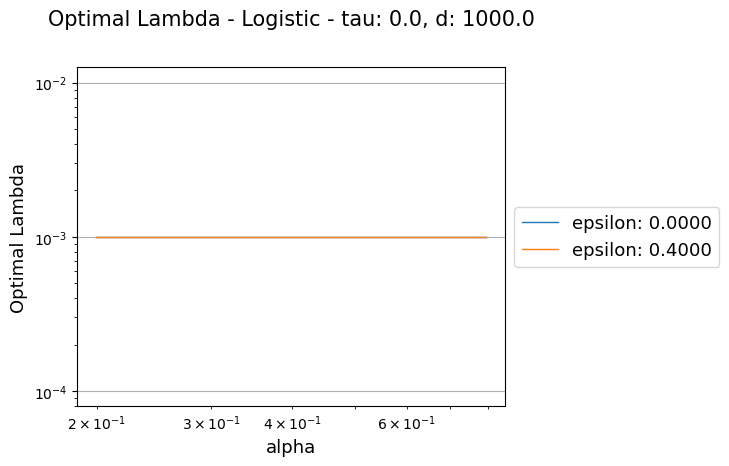

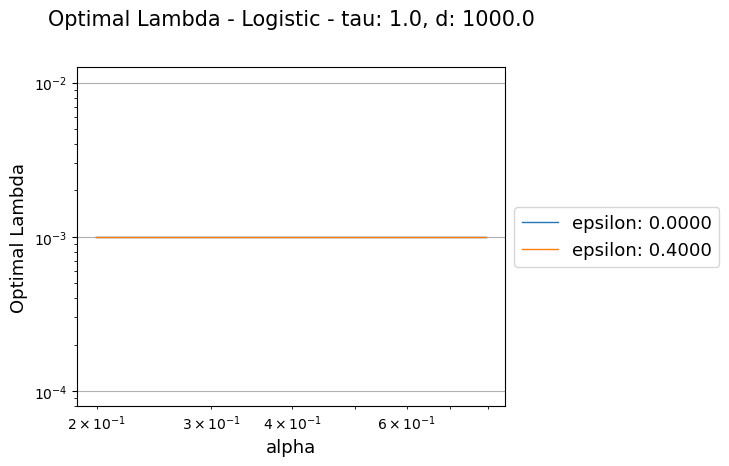

In [632]:
create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_24522/2716175861.py:98: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


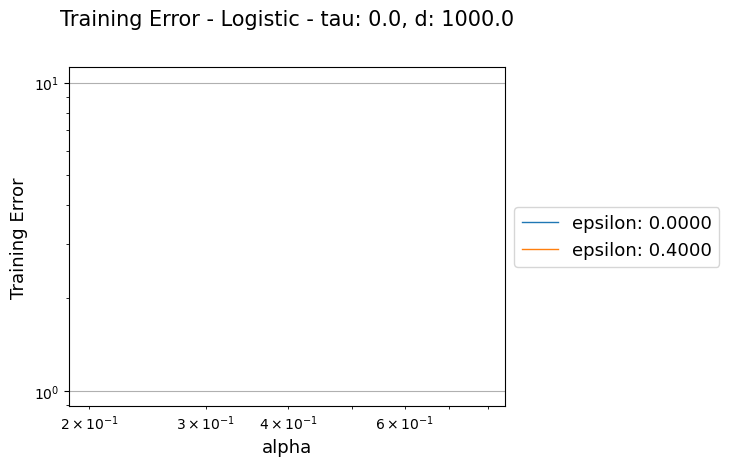

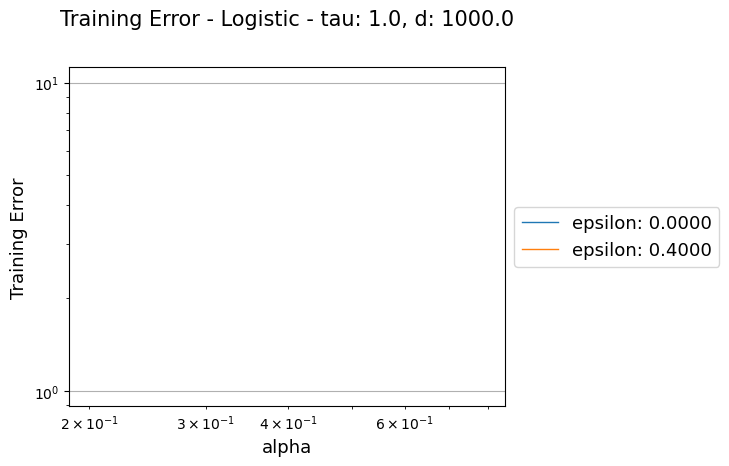

In [633]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

In [634]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

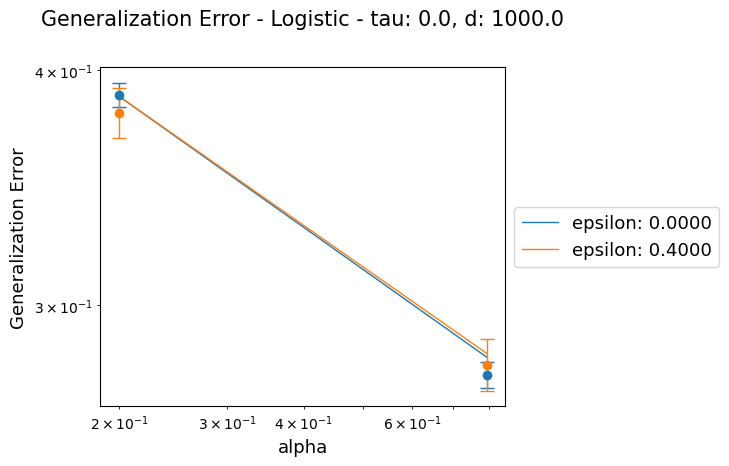

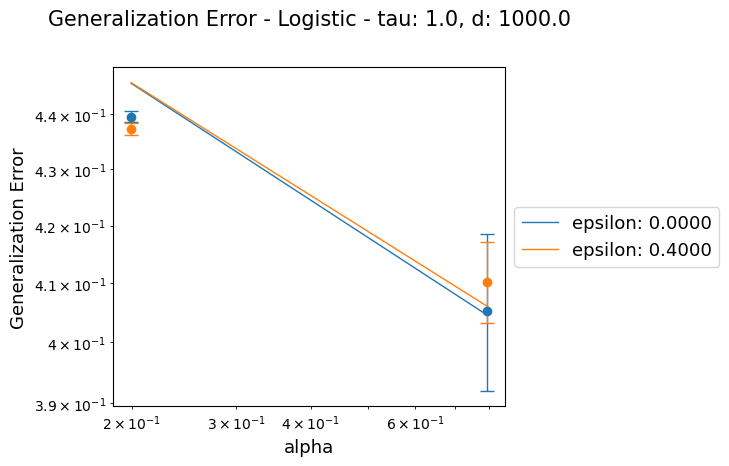

In [635]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

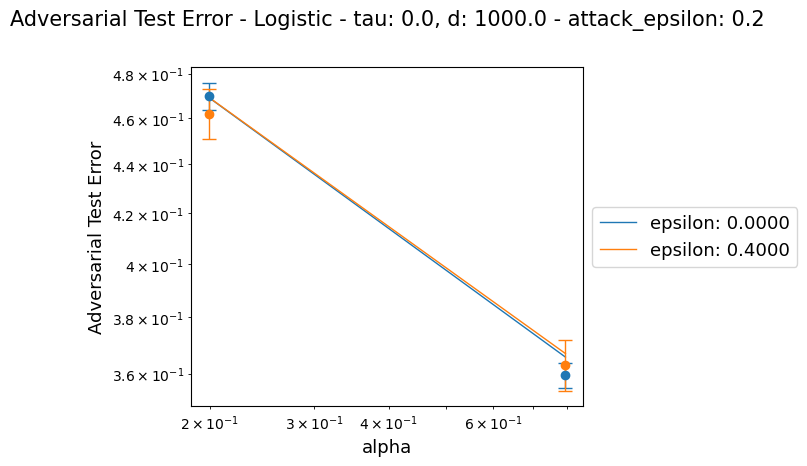

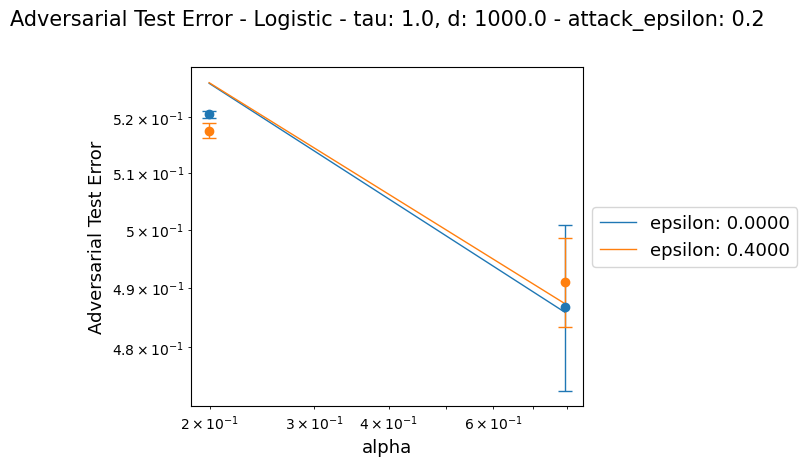

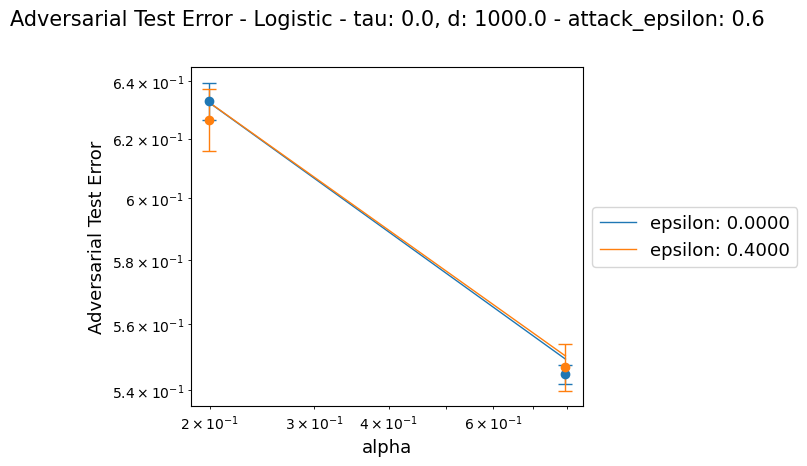

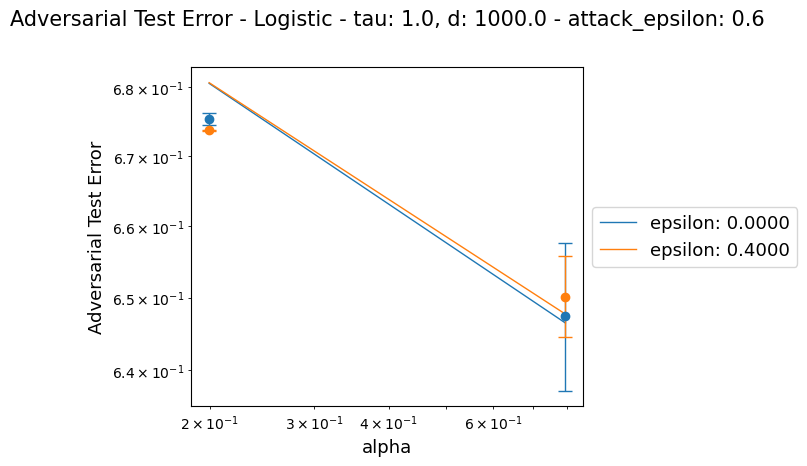

In [636]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

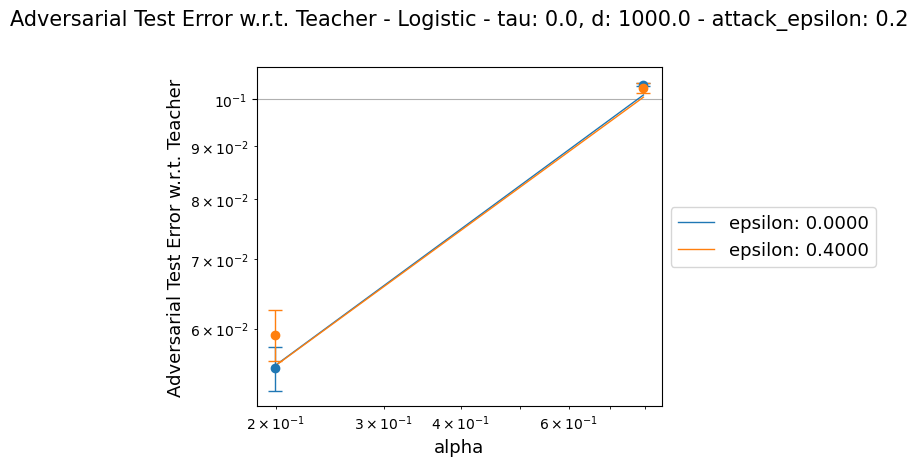

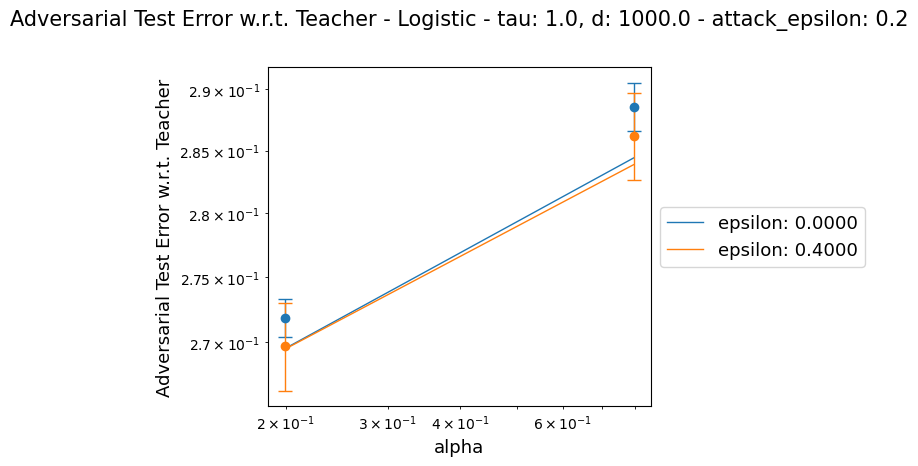

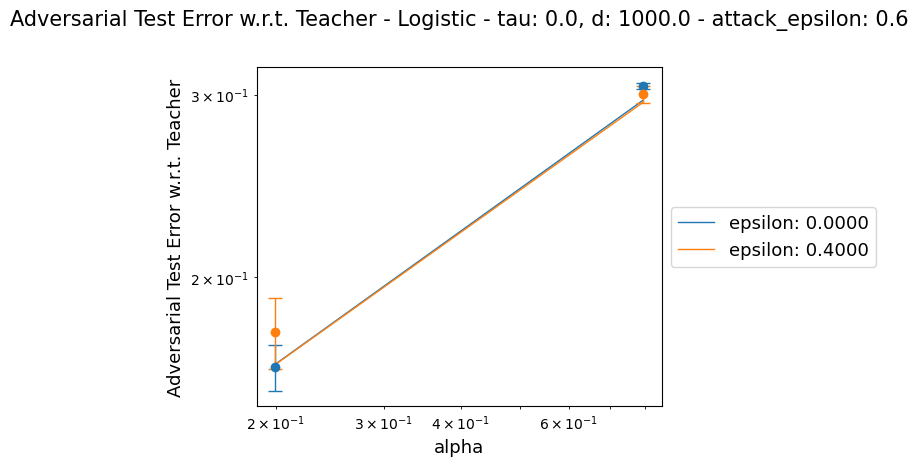

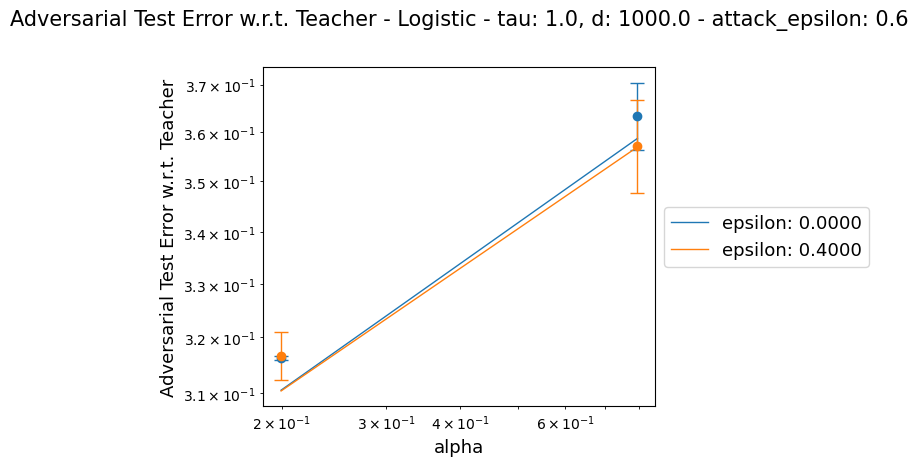

In [637]:
create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

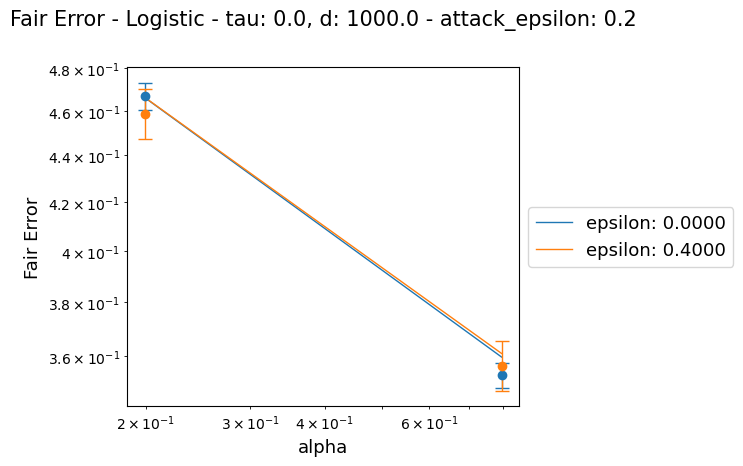

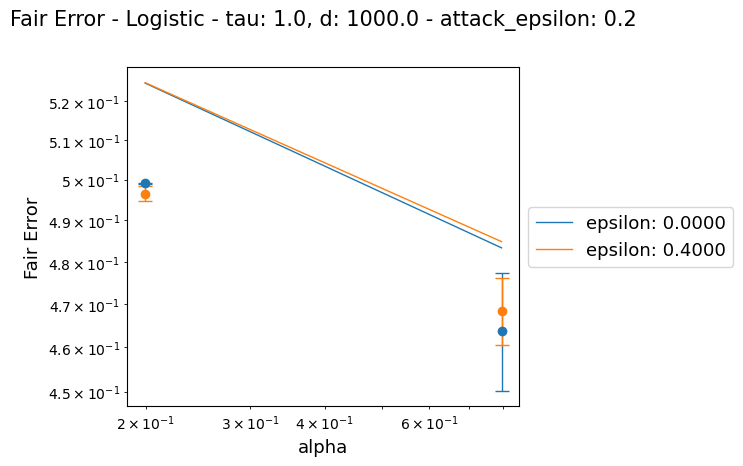

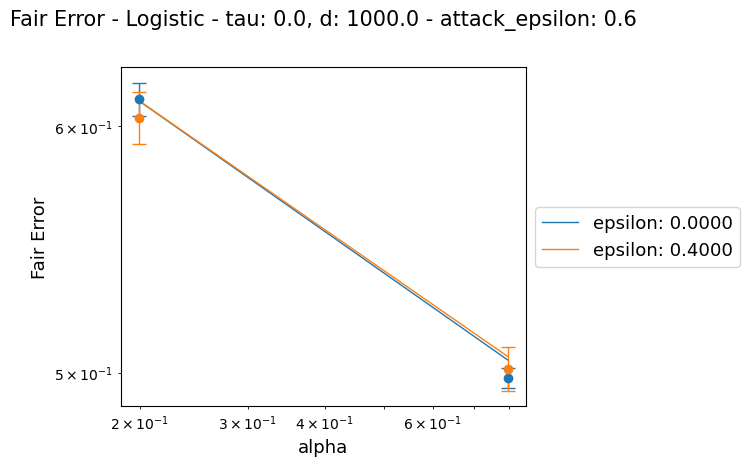

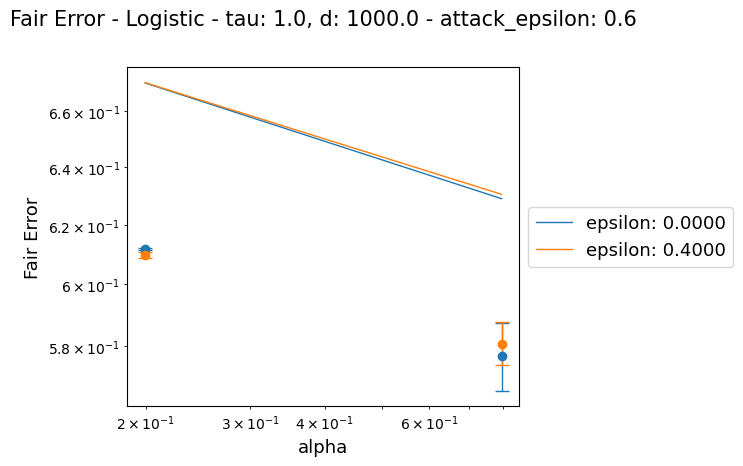

In [638]:
# plot the fair adversarial error
create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

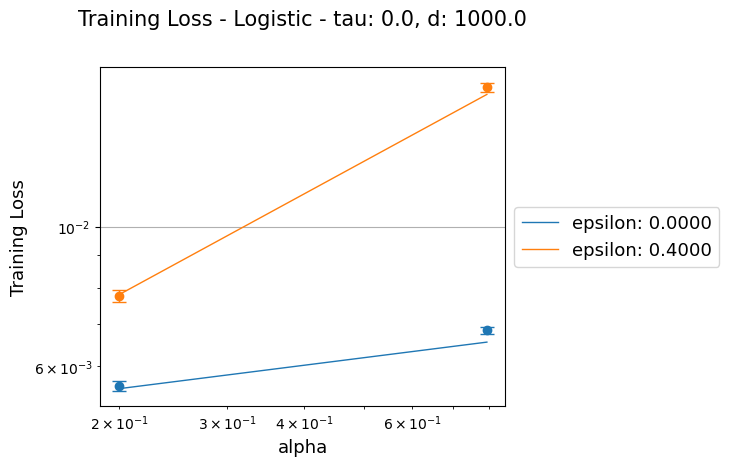

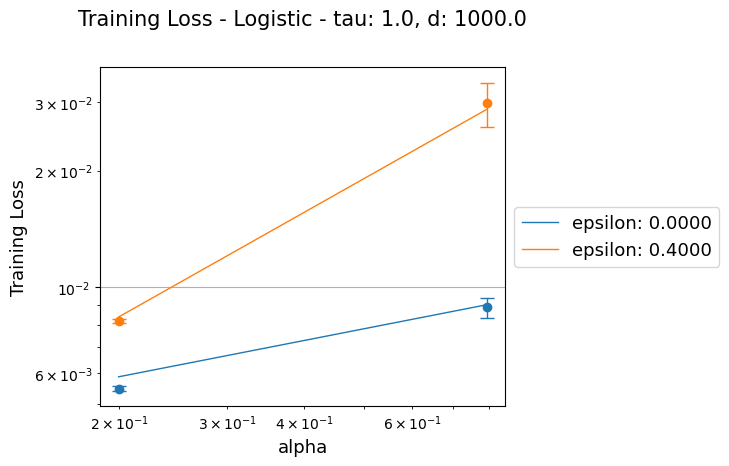

In [639]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

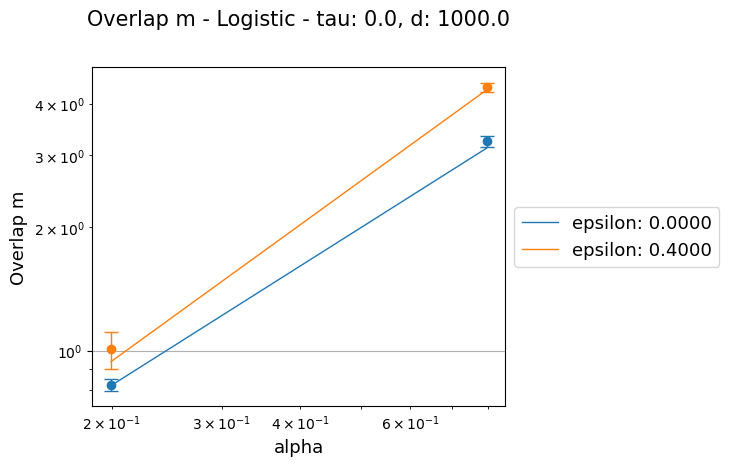

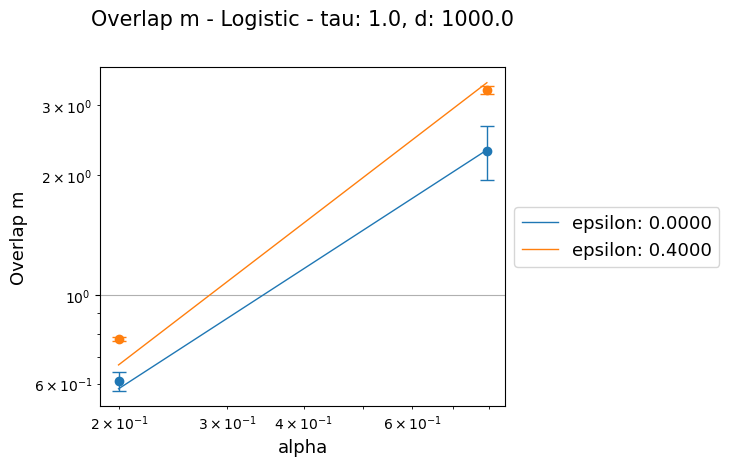

In [640]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

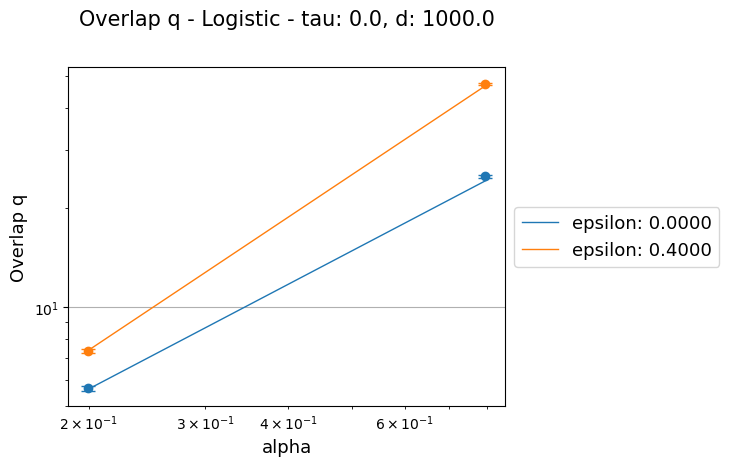

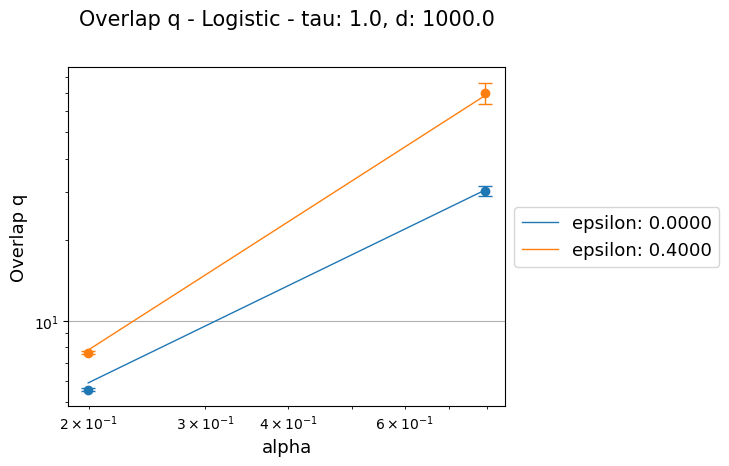

In [641]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

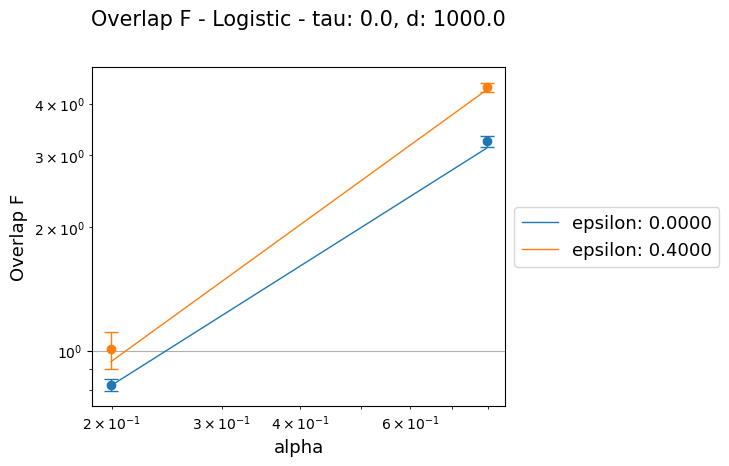

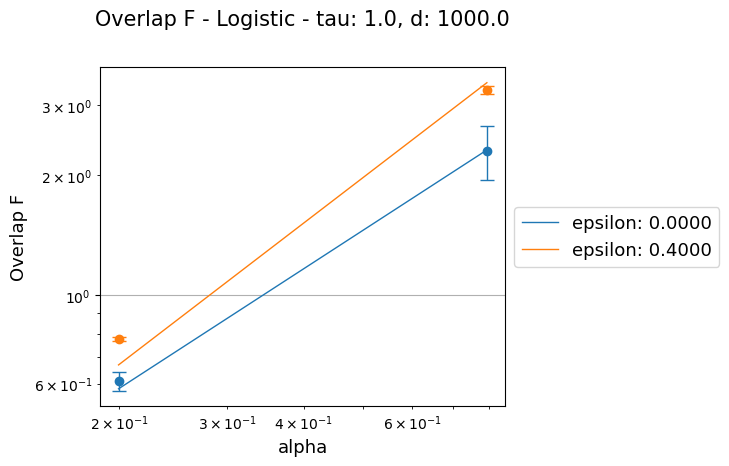

In [642]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

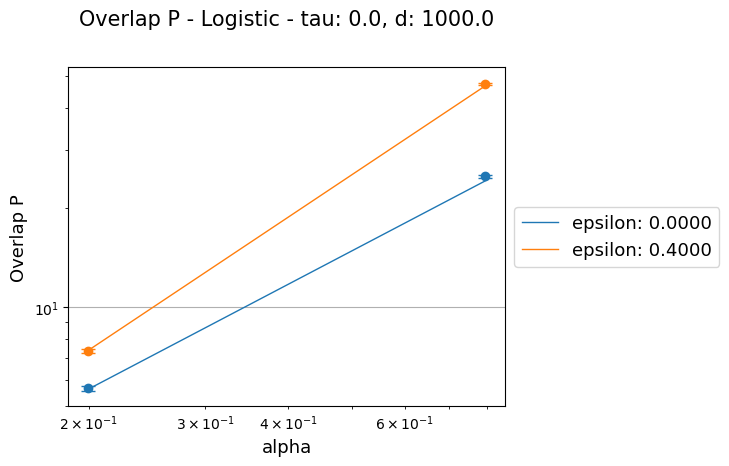

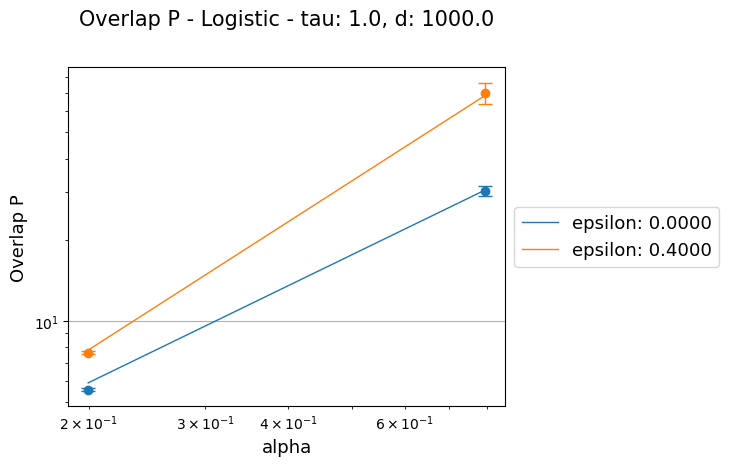

In [643]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

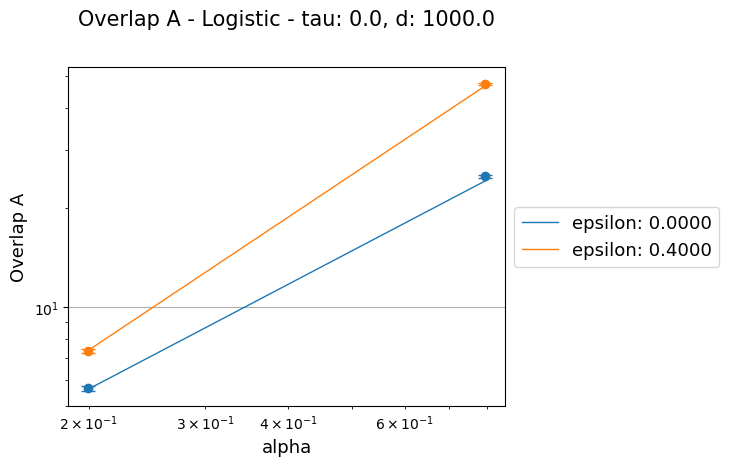

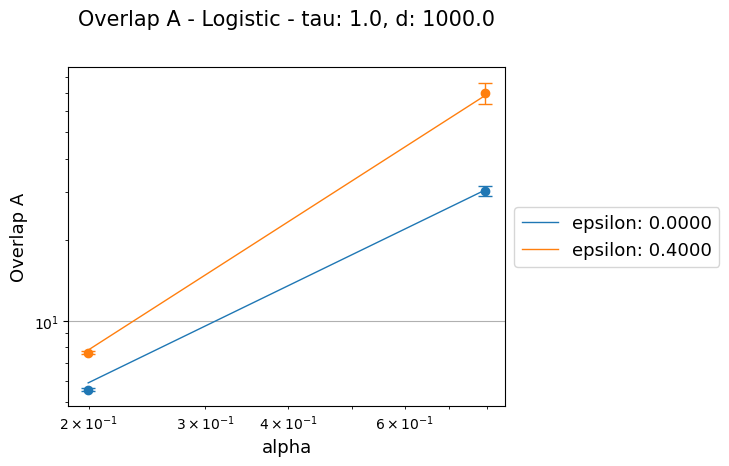

In [644]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

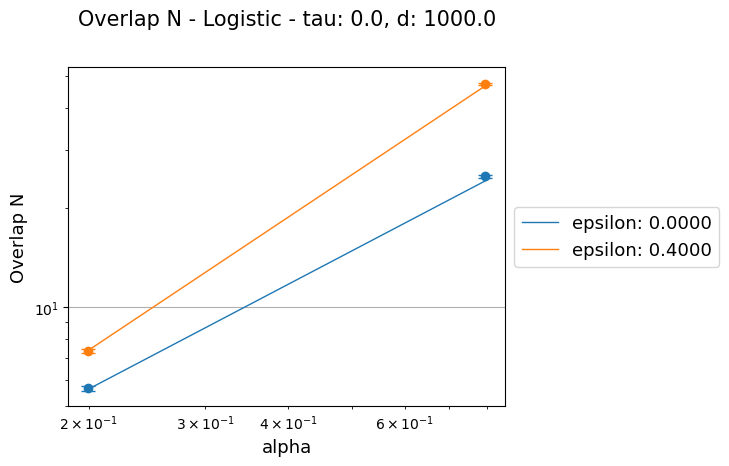

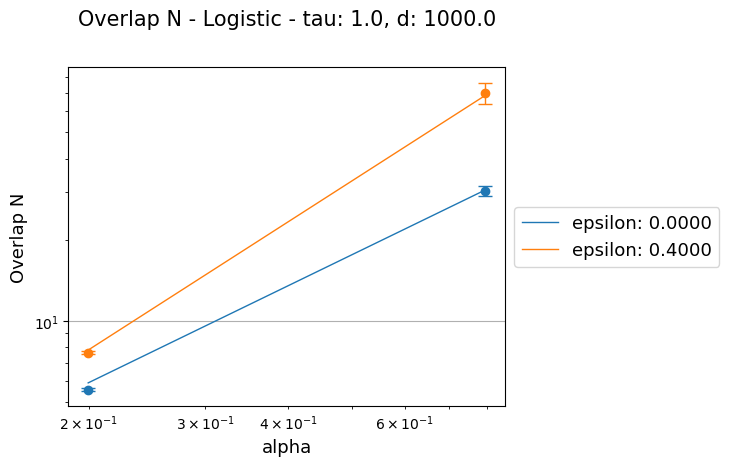

In [645]:
# Plot the N overlap
create_plot(df, "Overlap N", "N_state_evolution","N_erm", log_y=True)

In [646]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

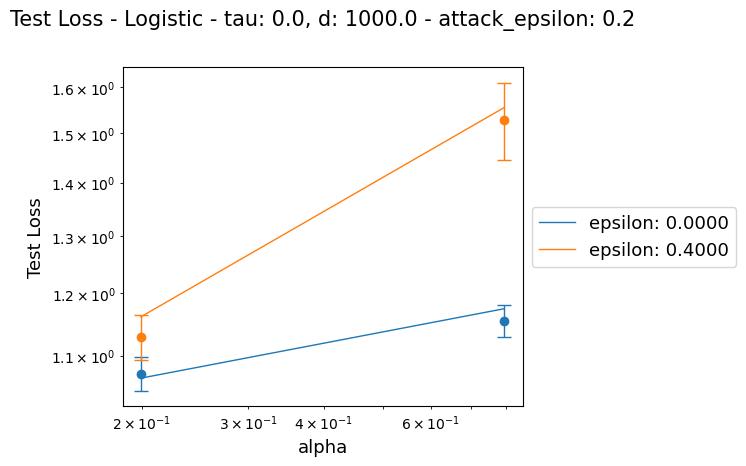

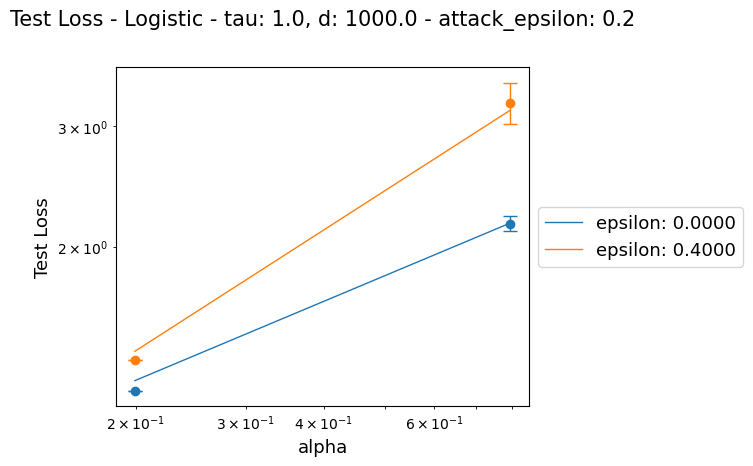

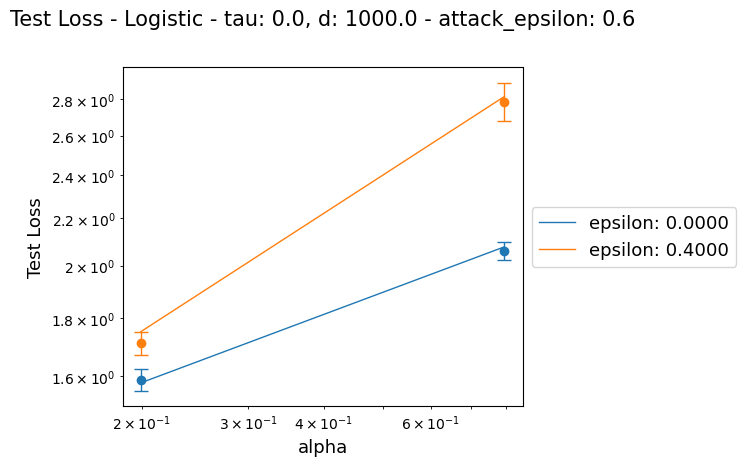

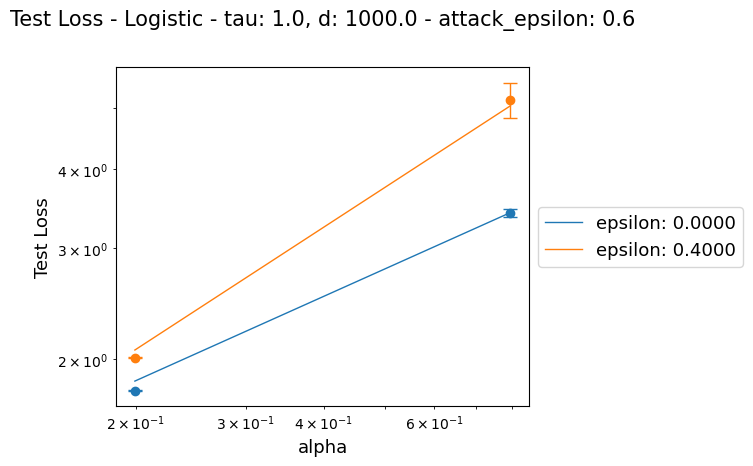

In [647]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

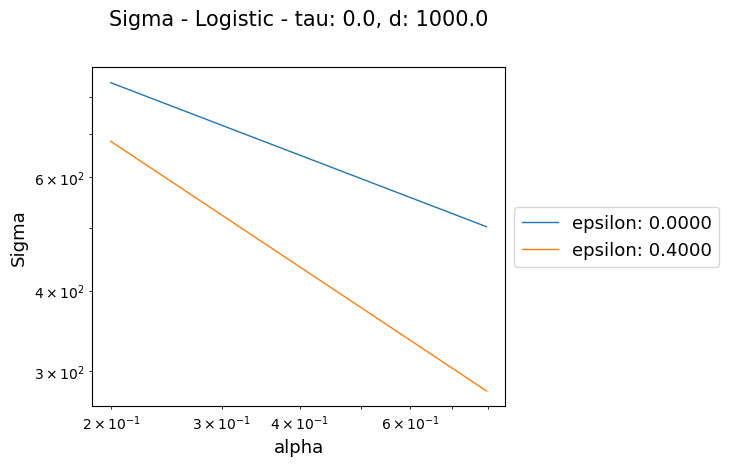

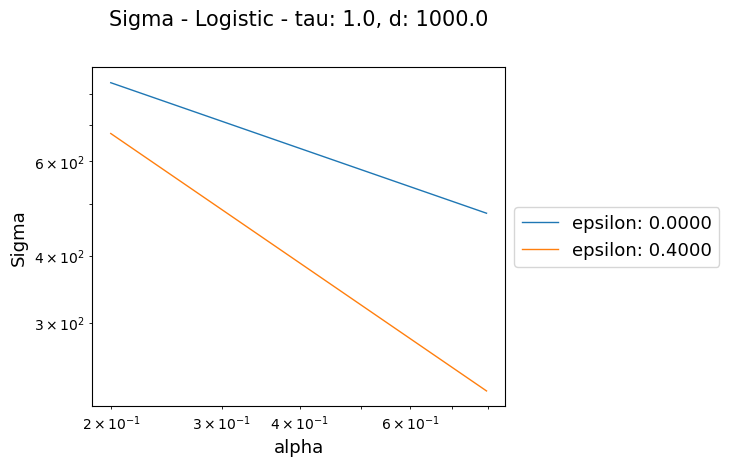

In [648]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None)

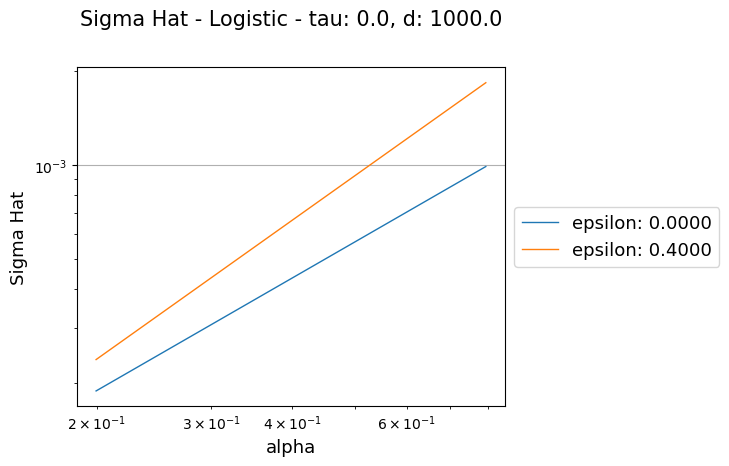

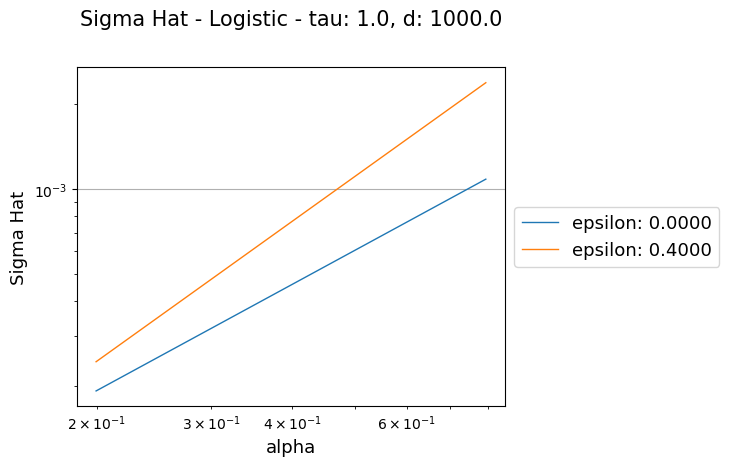

In [649]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None)

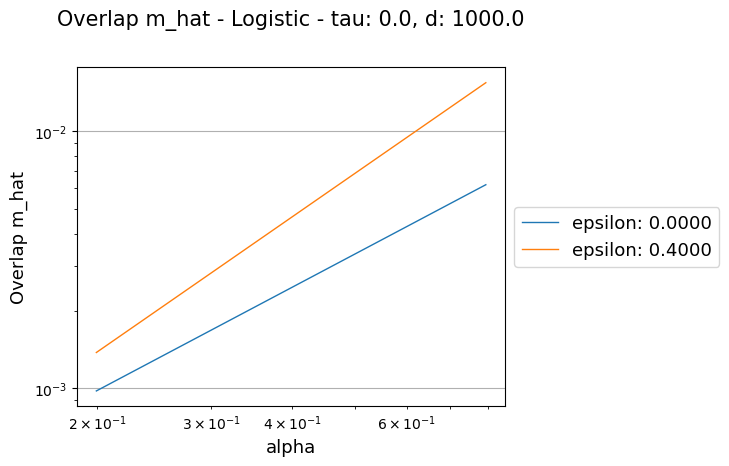

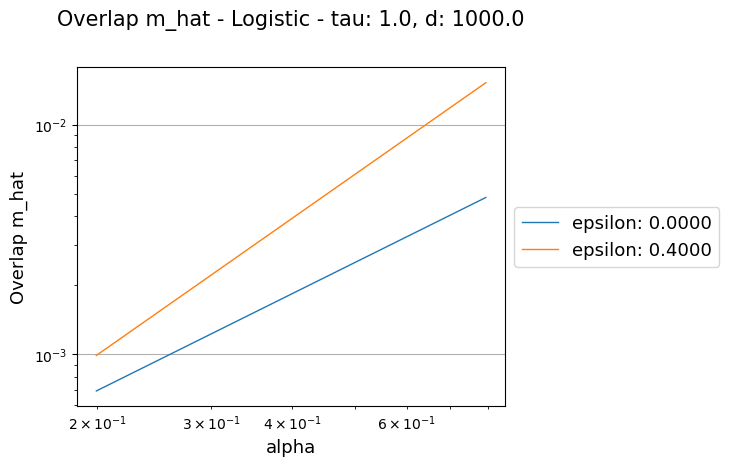

In [650]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None)

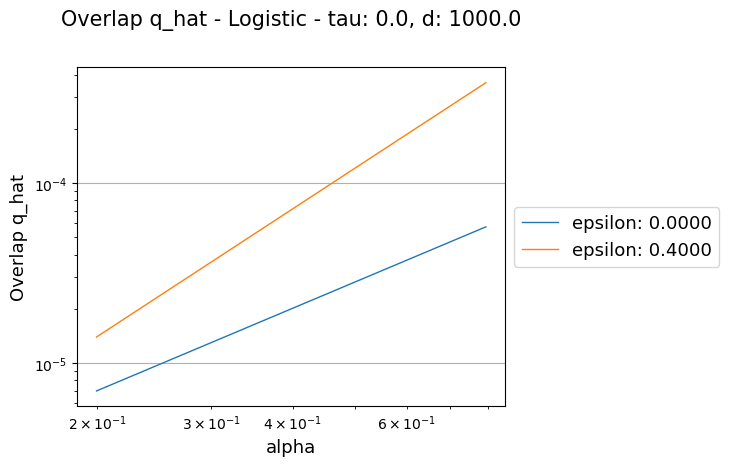

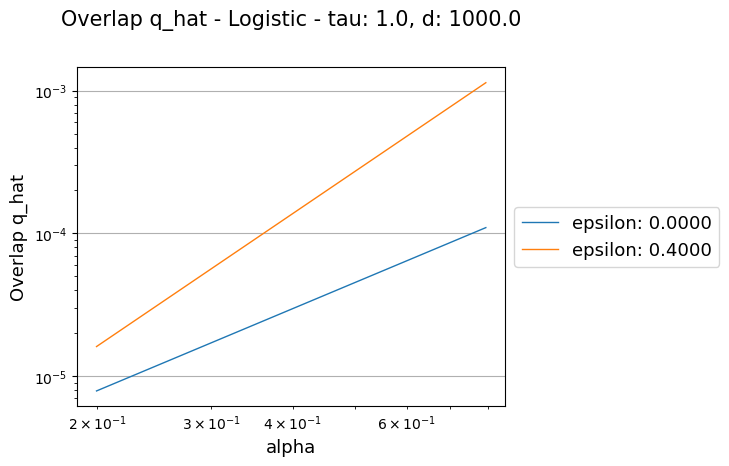

In [651]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None)

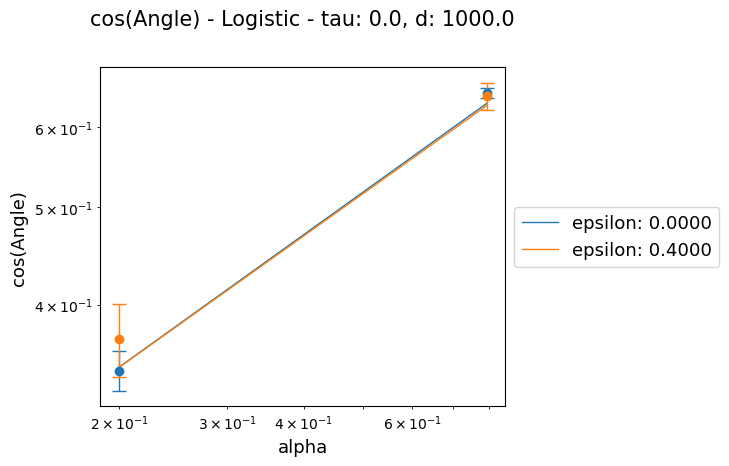

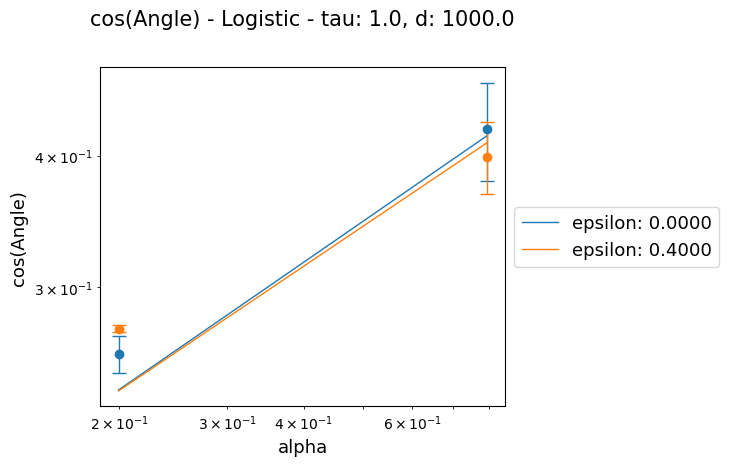

In [652]:
create_plot(df, "cos(Angle)", "angle_state_evolution","angle_erm")